# Plot average causal effects & Frozen-MLP causal tracing

In this notebook we run the causal tracing program, safe the results and plot the average causal effects for better visualization of the effects as well as the causal effects with isolated / frozen MLP modules

Model here is: gpt2-medium
Average over the forst 100 factual associations in the dataset knowns instead of all 1209 to safe some processing time

# Plot average causal effects

This script loads sets of hundreds of causal traces that have been computed by the
`experiment.causal_trace` program, and then aggregates the results to compute
Average Indirect Effects and Average Total Effects as well as some other information.


In [ ]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
cd /content && rm -rf /content/rome
git clone --branch CausalTracingTrials --single-branch https://github.com/khnhenriette/ProjectADL rome > install.log 2>&1
pip install -r /content/rome/scripts/colab_reqs/rome.txt >> install.log 2>&1
pip install --upgrade google-cloud-storage >> install.log 2>&1

In [ ]:
IS_COLAB = False
try:
    import google.colab, torch, os

    IS_COLAB = True
    os.chdir("/content/rome")
    if not torch.cuda.is_available():
        raise Exception("Change runtime type to include a GPU.")
except ModuleNotFoundError as _:
    pass

In [ ]:
!pip install datasets

  Using cached xxhash-3.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
Using cached xxhash-3.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (194 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# run the causal tracing on 100 factual associtations on gpt medium

!python causal_trace.py

tokenizer_config.json: 100% 26.0/26.0 [00:00<00:00, 86.9kB/s]
config.json: 100% 689/689 [00:00<00:00, 3.84MB/s]
vocab.json: 100% 1.04M/1.04M [00:01<00:00, 944kB/s]
merges.txt: 100% 456k/456k [00:00<00:00, 917kB/s]
tokenizer.json: 100% 1.36M/1.36M [00:00<00:00, 2.82MB/s]
2024-11-21 16:27:51.945172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 16:27:51.963638: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 16:27:51.969490: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 16:27:51.983675: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFl

Now that we have the results of the causal tracing in memory we can access them and plot the averaging figures to get a good overview of the average indirect effects of individual model components over a sample of 100 factual statements.

In [ ]:
import numpy, os
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Uncomment the architecture to plot.
arch = "gpt2-medium"
archname = "GPT-2-Medium"

# arch = "gpt2-xl"
# archname = "GPT-2-XL"

# arch = "EleutherAI_gpt-j-6B"
# archname = "GPT-J-6B

# arch = 'EleutherAI_gpt-j-6B'
# archname = 'GPT-J-6B'

# arch = 'EleutherAI_gpt-neox-20b'
# archname = 'GPT-NeoX-20B'


class Avg:
    def __init__(self):
        self.d = []

    def add(self, v):
        self.d.append(v[None])

    def add_all(self, vv):
        self.d.append(vv)

    def avg(self):
        return numpy.concatenate(self.d).mean(axis=0)

    def std(self):
        return numpy.concatenate(self.d).std(axis=0)

    def size(self):
        return sum(datum.shape[0] for datum in self.d)


def read_knowlege(count=150, kind=None, arch="gpt2-medium"):
    dirname = f"results/{arch}/causal_trace/cases/"
    kindcode = "" if not kind else f"_{kind}"
    (
        avg_fe,
        avg_ee,
        avg_le,
        avg_fa,
        avg_ea,
        avg_la,
        avg_hs,
        avg_ls,
        avg_fs,
        avg_fle,
        avg_fla,
    ) = [Avg() for _ in range(11)]
    for i in range(count):
        try:
            data = numpy.load(f"{dirname}/knowledge_{i}{kindcode}.npz")
        except:
            continue
        # Only consider cases where the model begins with the correct prediction
        if "correct_prediction" in data and not data["correct_prediction"]:
            continue
        scores = data["scores"]
        first_e, first_a = data["subject_range"]
        last_e = first_a - 1
        last_a = len(scores) - 1
        # original prediction
        avg_hs.add(data["high_score"])
        # prediction after subject is corrupted
        avg_ls.add(data["low_score"])
        avg_fs.add(scores.max())
        # some maximum computations
        avg_fle.add(scores[last_e].max())
        avg_fla.add(scores[last_a].max())
        # First subject middle, last subjet.
        avg_fe.add(scores[first_e])
        avg_ee.add_all(scores[first_e + 1 : last_e])
        avg_le.add(scores[last_e])
        # First after, middle after, last after
        avg_fa.add(scores[first_a])
        avg_ea.add_all(scores[first_a + 1 : last_a])
        avg_la.add(scores[last_a])

    result = numpy.stack(
        [
            avg_fe.avg(),
            avg_ee.avg(),
            avg_le.avg(),
            avg_fa.avg(),
            avg_ea.avg(),
            avg_la.avg(),
        ]
    )
    result_std = numpy.stack(
        [
            avg_fe.std(),
            avg_ee.std(),
            avg_le.std(),
            avg_fa.std(),
            avg_ea.std(),
            avg_la.std(),
        ]
    )
    print("Average Total Effect", avg_hs.avg() - avg_ls.avg())
    print(
        "Best average indirect effect on last subject",
        avg_le.avg().max() - avg_ls.avg(),
    )
    print(
        "Best average indirect effect on last token", avg_la.avg().max() - avg_ls.avg()
    )
    print("Average best-fixed score", avg_fs.avg())
    print("Average best-fixed on last subject token score", avg_fle.avg())
    print("Average best-fixed on last word score", avg_fla.avg())
    print("Argmax at last subject token", numpy.argmax(avg_le.avg()))
    print("Max at last subject token", numpy.max(avg_le.avg()))
    print("Argmax at last prompt token", numpy.argmax(avg_la.avg()))
    print("Max at last prompt token", numpy.max(avg_la.avg()))
    return dict(
        low_score=avg_ls.avg(), result=result, result_std=result_std, size=avg_fe.size()
    )


def plot_array(
    differences,
    kind=None,
    savepdf=None,
    title=None,
    low_score=None,
    high_score=None,
    archname="GPT2-Medium",
):
    if low_score is None:
        low_score = differences.min()
    if high_score is None:
        high_score = differences.max()
    answer = "AIE"
    labels = [
        "First subject token",
        "Middle subject tokens",
        "Last subject token",
        "First subsequent token",
        "Further tokens",
        "Last token",
    ]

    fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
    h = ax.pcolor(
        differences,
        cmap={None: "Purples", "mlp": "Greens", "attn": "Reds"}[kind],
        vmin=low_score,
        vmax=high_score,
    )
    if title:
        ax.set_title(title)
    ax.invert_yaxis()
    ax.set_yticks([0.5 + i for i in range(len(differences))])
    ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
    ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
    ax.set_yticklabels(labels)
    if kind is None:
        ax.set_xlabel(f"single patched layer within {archname}")
    else:
        ax.set_xlabel(f"center of interval of 10 patched {kind} layers")
    cb = plt.colorbar(h)
    # The following should be cb.ax.set_xlabel(answer), but this is broken in matplotlib 3.5.1.
    if answer:
        cb.ax.set_title(str(answer).strip(), y=-0.16, fontsize=10)

    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        plt.savefig(savepdf, bbox_inches="tight")
    plt.show()

# there are 1209 factual associations in the knowns dataset, i.e. numbered from 0 to 1208
the_count = 1208
high_score = None  # Scale all plots according to the y axis of the first plot

for kind in [None, "mlp", "attn"]:
    d = read_knowlege(the_count, kind, arch)
    count = d["size"]
    what = {
        None: "Indirect Effect of $h_i^{(l)}$",
        "mlp": "Indirect Effect of MLP",
        "attn": "Indirect Effect of Attn",
    }[kind]
    title = f"Avg {what} over {count} prompts"
    result = numpy.clip(d["result"] - d["low_score"], 0, None)
    kindcode = "" if kind is None else f"_{kind}"
    if kind not in ["mlp", "attn"]:
        high_score = result.max()
    plot_array(
        result,
        kind=kind,
        title=title,
        low_score=0.0,
        high_score=high_score,
        archname=archname,
        savepdf=f"results/{arch}/causal_trace/summary_pdfs/rollup{kindcode}.pdf",
    )

ValueError: need at least one array to concatenate

## Plot line graph

To make confidence intervals visible, we plot the data as line graphs below.

Reading None


ValueError: need at least one array to concatenate

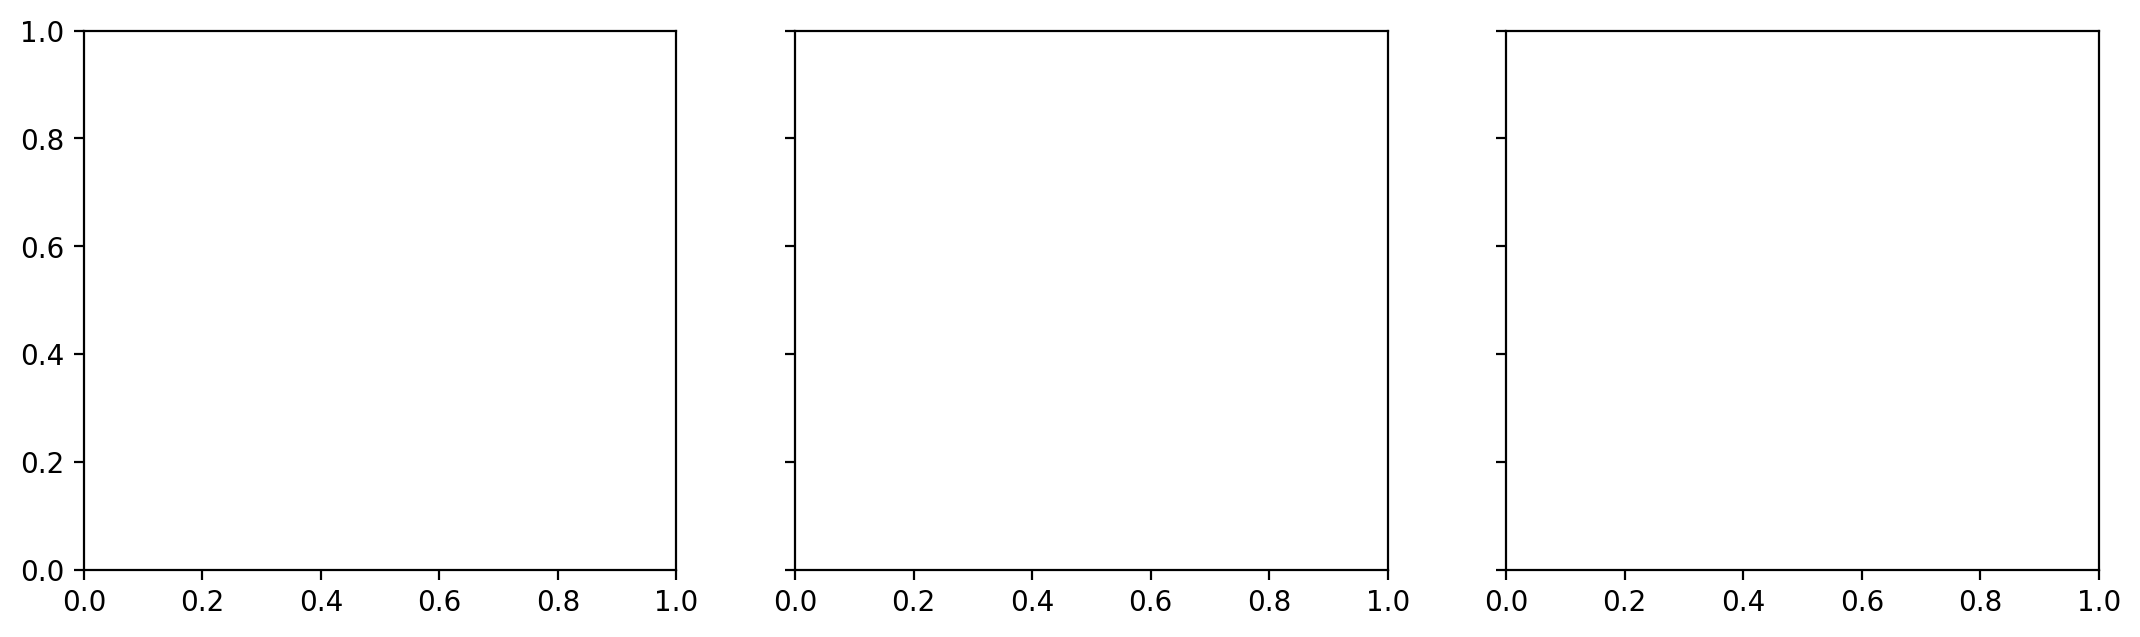

In [ ]:
import math

labels = [
    "First subject token",
    "Middle subject tokens",
    "Last subject token",
    "First subsequent token",
    "Further tokens",
    "Last token",
]
color_order = [0, 1, 2, 4, 5, 3]
x = None

cmap = plt.get_cmap("tab10")
fig, axes = plt.subplots(1, 3, figsize=(13, 3.5), sharey=True, dpi=200)
for j, (kind, title) in enumerate(
    [
        (None, "single hidden vector"),
        ("mlp", "run of 10 MLP lookups"),
        ("attn", "run of 10 Attn modules"),
    ]
):
    print(f"Reading {kind}")
    d = read_knowlege(225, kind, arch)
    for i, label in list(enumerate(labels)):
        y = d["result"][i] - d["low_score"]
        if x is None:
            x = list(range(len(y)))
        std = d["result_std"][i]
        error = std * 1.96 / math.sqrt(count)
        axes[j].fill_between(
            x, y - error, y + error, alpha=0.3, color=cmap.colors[color_order[i]]
        )
        axes[j].plot(x, y, label=label, color=cmap.colors[color_order[i]])

    axes[j].set_title(f"Average indirect effect of a {title}")
    axes[j].set_ylabel("Average indirect effect on p(o)")
    axes[j].set_xlabel(f"Layer number in {archname}")
    # axes[j].set_ylim(0.1, 0.3)
axes[1].legend(frameon=False)
plt.tight_layout()
plt.savefig(f"results/{arch}/causal_trace/summary_pdfs/lineplot-causaltrace.pdf")
plt.show()

# Frozen-MLP causal tracing

This notebook executes causal traces with all the MLP modules for a token disabled (we also do Attn modules separately), by freezing them at the corrupted state.

In [ ]:
# %load_ext autoreload
# %autoreload 2

In [ ]:
import os, re
import torch, numpy
import importlib, copy
import transformers
from collections import defaultdict
from util import nethook
from matplotlib import pyplot as plt
from experiments.causal_trace import (
    ModelAndTokenizer,
    make_inputs,
    predict_from_input,
    decode_tokens,
    layername,
    find_token_range,
    trace_with_patch,
    plot_trace_heatmap,
    collect_embedding_std,
)
from util.globals import DATA_DIR
from dsets import KnownsDataset

Load model and compute its corresponding noise level.

In [ ]:
model_name = "gpt2-medium"  # "gpt2-xl" or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=IS_COLAB,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

In [ ]:
knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts
noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
print(f"Using noise level {noise_level}")

## Tracing a single location

The strategy here is to use three interventions, rather than two:

1. As before, corrupt a subset of the input.
2. As before, restore a subset of the internal hidden states to see
   which ones restore the output.
3. But now, while doing so, freeze a set of MLP modules when processing
   the specific subject token, so that they are stuck in the corrupted
   state.  This reveals effect of the hidden states on everything
   except for those particular MLP executions.
   
This three-way intervention is implemented in `trace_with_repatch`

In [ ]:
def trace_with_repatch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    states_to_unpatch,  # A list of (token index, layername) triples to re-randomize
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    unpatch_spec = defaultdict(list)
    for t, l in states_to_unpatch:
        unpatch_spec[l].append(t)

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == "transformer.wte":
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if first_pass or (layer not in patch_spec and layer not in unpatch_spec):
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec.get(layer, []):
            h[1:, t] = h[0, t]
        for t in unpatch_spec.get(layer, []):
            h[1:, t] = untuple(first_pass_trace[layer].output)[1:, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    for first_pass in [True, False] if states_to_unpatch else [False]:
        with torch.no_grad(), nethook.TraceDict(
            model,
            ["transformer.wte"] + list(patch_spec.keys()) + list(unpatch_spec.keys()),
            edit_output=patch_rep,
        ) as td:
            outputs_exp = model(**inp)
            if first_pass:
                first_pass_trace = td

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    return probs

## Tracing all locations

Now we just need to repeat it over all locations, and draw the heatmaps.

In [ ]:
def calculate_hidden_flow_3(
    mt,
    prompt,
    subject,
    token_range=None,
    samples=10,
    noise=0.1,
    window=10,
    extra_token=0,
    disable_mlp=False,
    disable_attn=False,
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    if token_range == "last_subject":
        token_range = [e_range[1] - 1]
    e_range = (e_range[0], e_range[1] + extra_token)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()
    differences = trace_important_states_3(
        mt.model,
        mt.num_layers,
        inp,
        e_range,
        answer_t,
        noise=noise,
        disable_mlp=disable_mlp,
        disable_attn=disable_attn,
        token_range=token_range,
    )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind="",
    )


def trace_important_states_3(
    model,
    num_layers,
    inp,
    e_range,
    answer_t,
    noise=0.1,
    disable_mlp=False,
    disable_attn=False,
    token_range=None,
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    zero_mlps = []
    if token_range is None:
        token_range = range(ntoks)
    for tnum in token_range:
        zero_mlps = []
        if disable_mlp:
            zero_mlps = [
                (tnum, layername(model, L, "mlp")) for L in range(0, num_layers)
            ]
        if disable_attn:
            zero_mlps += [
                (tnum, layername(model, L, "attn")) for L in range(0, num_layers)
            ]
        row = []
        for layer in range(0, num_layers):
            r = trace_with_repatch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                zero_mlps,  # states_to_unpatch
                answer_t,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

Here is a causal trace with MLP disabled - it looks quite different from normal.

In [ ]:
prefix = "Megan Rapinoe plays the sport of"
entity = "Megan Rapinoe"

no_attn_r = calculate_hidden_flow_3(
    mt, prefix, entity, disable_mlp=True, noise=noise_level
)
plot_trace_heatmap(no_attn_r, title="Impact with MLP at last subject token disabled")
ordinary_r = calculate_hidden_flow_3(mt, prefix, entity, noise=noise_level)
plot_trace_heatmap(ordinary_r, title="Impact with MLP enabled as usual")

## Comparing the with-MLP/Attn and without-MLP/Attn traces

Plotting on a bar graph makes it easier to see the difference between the causal effects with and without MLP enabled.

In [ ]:
def plot_last_subject(mt, prefix, entity, token_range="last_subject", savepdf=None):
    ordinary, no_attn, no_mlp = calculate_last_subject(
        mt, prefix, entity, token_range=token_range
    )
    plot_comparison(ordinary, no_attn, no_mlp, prefix, savepdf=savepdf)


def calculate_last_subject(mt, prefix, entity, cache=None, token_range="last_subject"):
    def load_from_cache(filename):
        try:
            dat = numpy.load(f"{cache}/{filename}")
            return {
                k: v
                if not isinstance(v, numpy.ndarray)
                else str(v)
                if v.dtype.type is numpy.str_
                else torch.from_numpy(v)
                for k, v in dat.items()
            }
        except FileNotFoundError as e:
            return None

    no_attn_r = load_from_cache("no_attn_r.npz")
    uncached_no_attn_r = no_attn_r is None
    no_mlp_r = load_from_cache("no_mlp_r.npz")
    uncached_no_mlp_r = no_mlp_r is None
    ordinary_r = load_from_cache("ordinary.npz")
    uncached_ordinary_r = ordinary_r is None
    if uncached_no_attn_r:
        no_attn_r = calculate_hidden_flow_3(
            mt,
            prefix,
            entity,
            disable_attn=True,
            token_range=token_range,
            noise=noise_level,
        )
    if uncached_no_mlp_r:
        no_mlp_r = calculate_hidden_flow_3(
            mt,
            prefix,
            entity,
            disable_mlp=True,
            token_range=token_range,
            noise=noise_level,
        )
    if uncached_ordinary_r:
        ordinary_r = calculate_hidden_flow_3(
            mt, prefix, entity, token_range=token_range, noise=noise_level
        )
    if cache is not None:
        os.makedirs(cache, exist_ok=True)
        for u, r, filename in [
            (uncached_no_attn_r, no_attn_r, "no_attn_r.npz"),
            (uncached_no_mlp_r, no_mlp_r, "no_mlp_r.npz"),
            (uncached_ordinary_r, ordinary_r, "ordinary.npz"),
        ]:
            if u:
                numpy.savez(
                    f"{cache}/{filename}",
                    **{
                        k: v.cpu().numpy() if torch.is_tensor(v) else v
                        for k, v in r.items()
                    },
                )
    if False:
        return (ordinary_r["scores"][0], no_attn_r["scores"][0], no_mlp_r["scores"][0])
    return (
        ordinary_r["scores"][0] - ordinary_r["low_score"],
        no_attn_r["scores"][0] - ordinary_r["low_score"],
        no_mlp_r["scores"][0] - ordinary_r["low_score"],
    )

    # return ordinary_r['scores'][0], no_attn_r['scores'][0]


def plot_comparison(ordinary, no_attn, no_mlp, title, savepdf=None):
    with plt.rc_context(rc={"font.family": "DejaVu Serif"}):
        import matplotlib.ticker as mtick

        fig, ax = plt.subplots(1, figsize=(6, 1.5), dpi=300)
        ax.bar(
            [i - 0.3 for i in range(len(ordinary))],
            ordinary,
            width=0.3,
            color="#7261ab",
            label="Impact of single state on P",
        )
        ax.bar(
            [i for i in range(len(no_attn))],
            no_attn,
            width=0.3,
            color="#f3201b",
            label="Impact with Attn severed",
        )
        ax.bar(
            [i + 0.3 for i in range(len(no_mlp))],
            no_mlp,
            width=0.3,
            color="#20b020",
            label="Impact with MLP severed",
        )
        ax.set_title(
            title
        )  #'Impact of individual hidden state at last subject token with MLP disabled')
        ax.set_ylabel("Indirect Effect")
        # ax.set_xlabel('Layer at which the single hidden state is restored')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.set_ylim(None, max(0.025, ordinary.max() * 1.05))
        ax.legend()
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()


if False:  # Some representative cases.
    plot_last_subject(mt, "Megan Rapinoe plays the sport of", "Megan Rapinoe")
    plot_last_subject(mt, "The Big Bang Theory premires on", "The Big Bang Theory")
    plot_last_subject(mt, "Germaine Greer's domain of work is", "Germaine Greer")
    plot_last_subject(mt, "Brian de Palma works in the area of", "Brian de Palma")
    plot_last_subject(mt, "The headquarter of Zillow is in downtown", "Zillow")
    plot_last_subject(
        mt,
        "Mitsubishi Electric started in the 1900s as a small company in",
        "Mitsubishi",
    )
    plot_last_subject(
        mt,
        "Mitsubishi Electric started in the 1900s as a small company in",
        "Mitsubishi Electric",
    )
    plot_last_subject(mt, "Madame de Montesson died in the city of", "Madame")
    plot_last_subject(
        mt, "Madame de Montesson died in the city of", "Madame de Montesson"
    )
    plot_last_subject(mt, "Edmund Neupert, performing on the", "Edmund Neupert")

In [ ]:
plot_last_subject(mt, "The Space Needle is in the city of", "The Space Needle")

## Average Indirect Effects

Now we average over the first 100 of the factual statements.

In [ ]:
import tqdm

knowns = KnownsDataset(DATA_DIR)
all_ordinary = []
all_no_attn = []
all_no_mlp = []
for i, knowledge in enumerate(tqdm.tqdm(knowns[:100])):
    # plot_all_flow(mt, knowledge['prompt'], knowledge['subject'])
    ordinary, no_attn, no_mlp = calculate_last_subject(
        mt,
        knowledge["prompt"],
        knowledge["subject"],
        cache=f"results/ct_disable_attn/case_{i}",
    )
    all_ordinary.append(ordinary)
    all_no_attn.append(no_attn)
    all_no_mlp.append(no_mlp)
title = "Causal effect of states at the early site with Attn or MLP modules severed"

avg_ordinary = torch.stack(all_ordinary).mean(dim=0)
avg_no_attn = torch.stack(all_no_attn).mean(dim=0)
avg_no_mlp = torch.stack(all_no_mlp).mean(dim=0)
import matplotlib.ticker as mtick

with plt.rc_context(rc={"font.family": "DejaVu Serif"}):
    fig, ax = plt.subplots(1, figsize=(6, 2.1), dpi=300)
    ax.bar(
        [i - 0.3 for i in range(48)],
        avg_ordinary,
        width=0.3,
        color="#7261ab",
        label="Effect of single state on P",
    )
    ax.bar(
        [i for i in range(48)],
        avg_no_attn,
        width=0.3,
        color="#f3201b",
        label="Effect with Attn severed",
    )
    ax.bar(
        [i + 0.3 for i in range(48)],
        avg_no_mlp,
        width=0.3,
        color="#20b020",
        label="Effect with MLP severed",
    )
    ax.set_title(
        title
    )  #'Impact of individual hidden state at last subject token with MLP disabled')
    ax.set_ylabel("Average Indirect Effect")
    ax.set_xlabel("Layer at which the single hidden state is restored")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_ylim(None, max(0.025, 0.105))

    ax.legend(frameon=False)
fig.savefig("causal-trace-no-attn-mlp.pdf", bbox_inches="tight")
print([d[20] - d[10] for d in [avg_ordinary, avg_no_attn, avg_no_mlp]])
print(avg_ordinary[15], avg_no_attn[15], avg_no_mlp[15])